In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [6]:
data = pd.read_csv(r'/kaggle/input/tesla-stock-pricing-20172022/TSLA.csv')

0    25.666668
1    25.006666
2    24.927334
3    24.431999
4    23.406000
Name: Close, dtype: float64

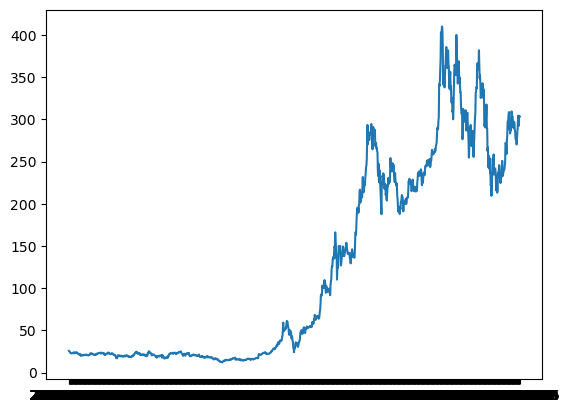

In [7]:
df=data.reset_index()['Close']
plt.plot(data['Date'],df)
df.head()

In [8]:
# 資料 scaling
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [9]:
#法Ａ
#splitting dataset into train and test split
'''
training_size=int(len(df1)*0.7)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
'''
#法Ｂ
#這個方法錯誤！ 為什麼？ 提示：random_state
'''
from sklearn.model_selection import train_test_split
X = df1
y = df1
train_data, test_data, _, _ = train_test_split(X,y,test_size=0.3,random_state=0)
'''
#法Ｃ
#不要 shuffle
#https://stackoverflow.com/questions/43838052/how-to-get-a-non-shuffled-train-test-split-in-sklearn
from sklearn.model_selection import train_test_split
X = df1
y = df1
train_data, test_data, _, _ = train_test_split(X,y,test_size=0.3, shuffle=False)

In [10]:
print(train_data.shape)
print(test_data.shape)

(881, 1)
(378, 1)


In [11]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX = []
    dataY = []
    for i in range(len(dataset)-time_step):#N,n,t.....n=t+2
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----9
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [12]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(871, 10)
(871,)
(368, 10)
(368,)


In [13]:
# reshape input to be [samples, time steps, features] which is required for LSTM

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print(X_train.shape), print(X_test.shape)

(871, 10, 1)
(368, 10, 1)


(None, None)

In [14]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [15]:
#LSTM魔法陣
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))#input10,output50
model.add(LSTM(50,return_sequences=True))#output50，input來自前面
model.add(LSTM(50))#output50，input來自前面


model.add(Dense(1))#收斂為1
model.compile(loss='mean_squared_error',optimizer='adam')#

In [16]:
model.summary()
#none值就是不要specify它
#取決於電腦cpu

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)
#none = batch_size=64
#epocha = 回合

Epoch 1/100
14/14 [==============================] - 8s 93ms/step - loss: 0.0246 - val_loss: 0.0245
Epoch 2/100
14/14 [==============================] - 0s 17ms/step - loss: 0.0027 - val_loss: 0.0042
Epoch 3/100
14/14 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 4/100
14/14 [==============================] - 0s 9ms/step - loss: 7.3547e-04 - val_loss: 0.0037
Epoch 5/100
14/14 [==============================] - 0s 9ms/step - loss: 6.0303e-04 - val_loss: 0.0041
Epoch 6/100
14/14 [==============================] - 0s 9ms/step - loss: 5.4634e-04 - val_loss: 0.0034
Epoch 7/100
14/14 [==============================] - 0s 10ms/step - loss: 5.3015e-04 - val_loss: 0.0034
Epoch 8/100
14/14 [==============================] - 0s 9ms/step - loss: 5.0006e-04 - val_loss: 0.0035
Epoch 9/100
14/14 [==============================] - 0s 9ms/step - loss: 4.9006e-04 - val_loss: 0.0034
Epoch 10/100
14/14 [==============================] - 0s 9ms/step - loss: 4.7426e

In [18]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

12/12 [==============================] - 0s 3ms/step


In [19]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
#因為標準化過
train_predict

array([[ 23.288065 ],
       [ 23.084578 ],
       [ 22.996193 ],
       [ 23.042448 ],
       [ 23.18151  ],
       [ 23.36112  ],
       [ 23.468122 ],
       [ 23.550484 ],
       [ 23.615301 ],
       [ 23.67113  ],
       [ 23.719517 ],
       [ 23.732061 ],
       [ 23.74216  ],
       [ 23.783133 ],
       [ 23.808062 ],
       [ 23.77116  ],
       [ 23.624704 ],
       [ 23.418966 ],
       [ 23.135069 ],
       [ 22.817137 ],
       [ 22.486082 ],
       [ 22.17038  ],
       [ 21.966558 ],
       [ 21.833138 ],
       [ 21.624388 ],
       [ 21.369656 ],
       [ 21.092878 ],
       [ 20.851517 ],
       [ 20.653355 ],
       [ 20.502316 ],
       [ 20.392569 ],
       [ 20.385578 ],
       [ 20.445889 ],
       [ 20.536915 ],
       [ 20.625704 ],
       [ 20.724995 ],
       [ 20.788122 ],
       [ 20.85787  ],
       [ 20.91013  ],
       [ 20.953066 ],
       [ 20.995707 ],
       [ 21.051352 ],
       [ 21.05186  ],
       [ 21.005049 ],
       [ 20.918941 ],
       [ 2

In [20]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))
#算performancem,越小越好

90.28490414849698

In [21]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

281.2537551581866

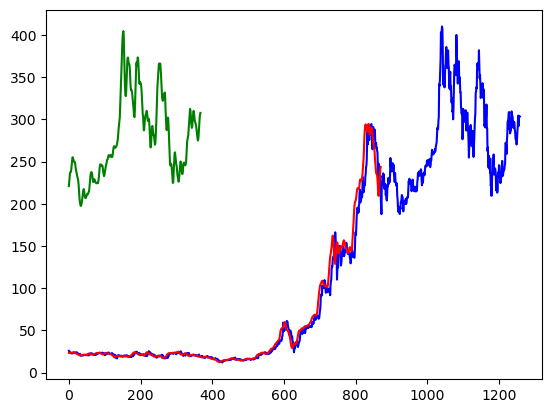

In [22]:
plt.plot(scaler.inverse_transform(df1),'blue')
plt.plot(train_predict,'red')
plt.plot(test_predict,'green')
plt.show()

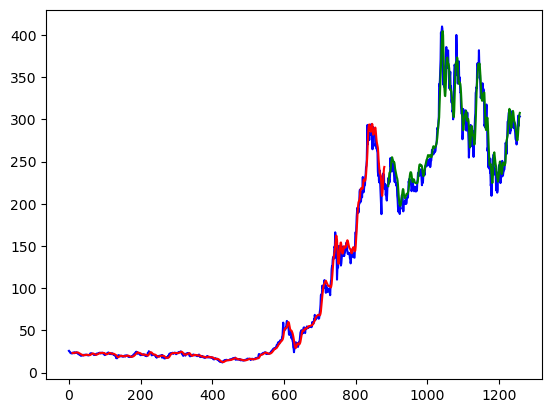

In [23]:
### Plotting 
# shift train predictions for plotting
time_step=10
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict)+time_step, :] = train_predict#平移
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(time_step*2):len(df1), :] = test_predict


# plot baseline and predictions

plt.plot(scaler.inverse_transform(df1),'blue')
plt.plot(trainPredictPlot,'red')
plt.plot(testPredictPlot,'green')
plt.show()